In [1]:
pip install azure-search-documents

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


#### Importing Azure Libaries
* azure.search.documents: Imports SearchClient, which allows you to interact with Azure Cognitive Search.
* azure.core.credentials: Imports AzureKeyCredential for authentication.


In [4]:
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
import pandas as pd
import re
import json

#### Defining azure seach settings
* service_name: The name of the Azure Cognitive Search service.
* index_name: The name of the search index where the documents will be uploaded.
* admin_key: The API key used for authentication.
* endpoint: The URL endpoint for the Azure Search service.
* credential: An instance of AzureKeyCredential initialized with the API key.

In [7]:
from dotenv import load_dotenv
import os
load_dotenv('kloop.env')
admin_key = os.getenv('AZURE_ADMIN_KEY')
service_name = 'kloop-chat'
index_name = 'kloop_data'
endpoint = f"https://{service_name}.search.windows.net/"
credential = AzureKeyCredential(admin_key)

#### Loading the data in to dataframe(Only in the case of csv files, each type would have different data preparation)
* file_path: Specifies the path to the CSV file containing the customer support ticket data.
* pd.read_csv(file_path): Loads the CSV data into a pandas DataFrame.
* df.dropna(): Removes any rows in the DataFrame that contain null values, ensuring that only complete data entries are processed.

In [8]:
file_path = 'customer_support_tickets.csv'

df = pd.read_csv(file_path)
df_cleaned = df.dropna()

In [9]:
df_cleaned.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
10,11,Joseph Moreno,mbrown@example.org,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,2023-06-01 17:46:49,2023-05-31 23:51:49,1.0
11,12,Brandon Arnold,davisjohn@example.net,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,2023-06-01 12:05:51,2023-06-01 09:27:51,1.0


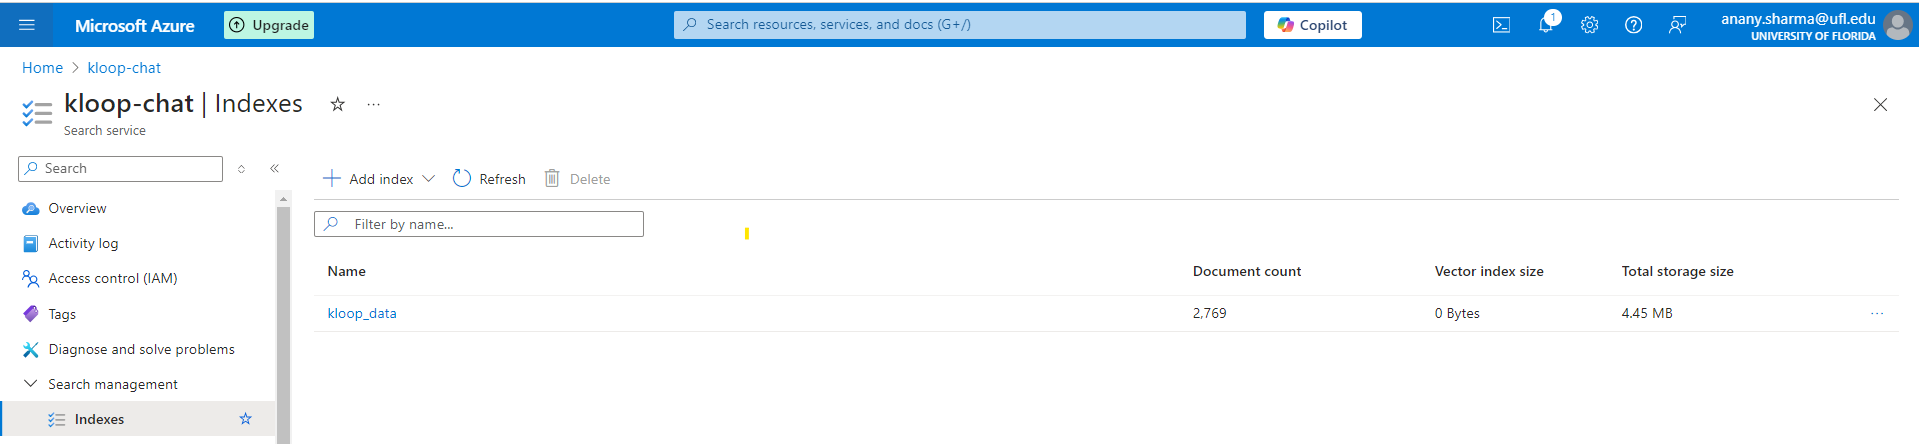

In [10]:
from IPython.display import Image
Image('kloop_index.png', width=600, height=600)

In [11]:
# Creating the seachr client object fro indexing data
searchclient = SearchClient(endpoint=endpoint, index_name=index_name,credential=credential)
data = []

#### Preparing data to upload
* data = []: Initializes an empty list to hold the documents to be uploaded.
* for _, row in df_cleaned.iterrows(): Iterates over each row in the cleaned DataFrame.
* For each row, a dictionary is created with keys corresponding to the index fields defined in the Azure Search index.
* The key @search.action is set to 'upload', indicating that the document is to be uploaded.
* Each field is extracted from the DataFrame and converted to the appropriate data type.

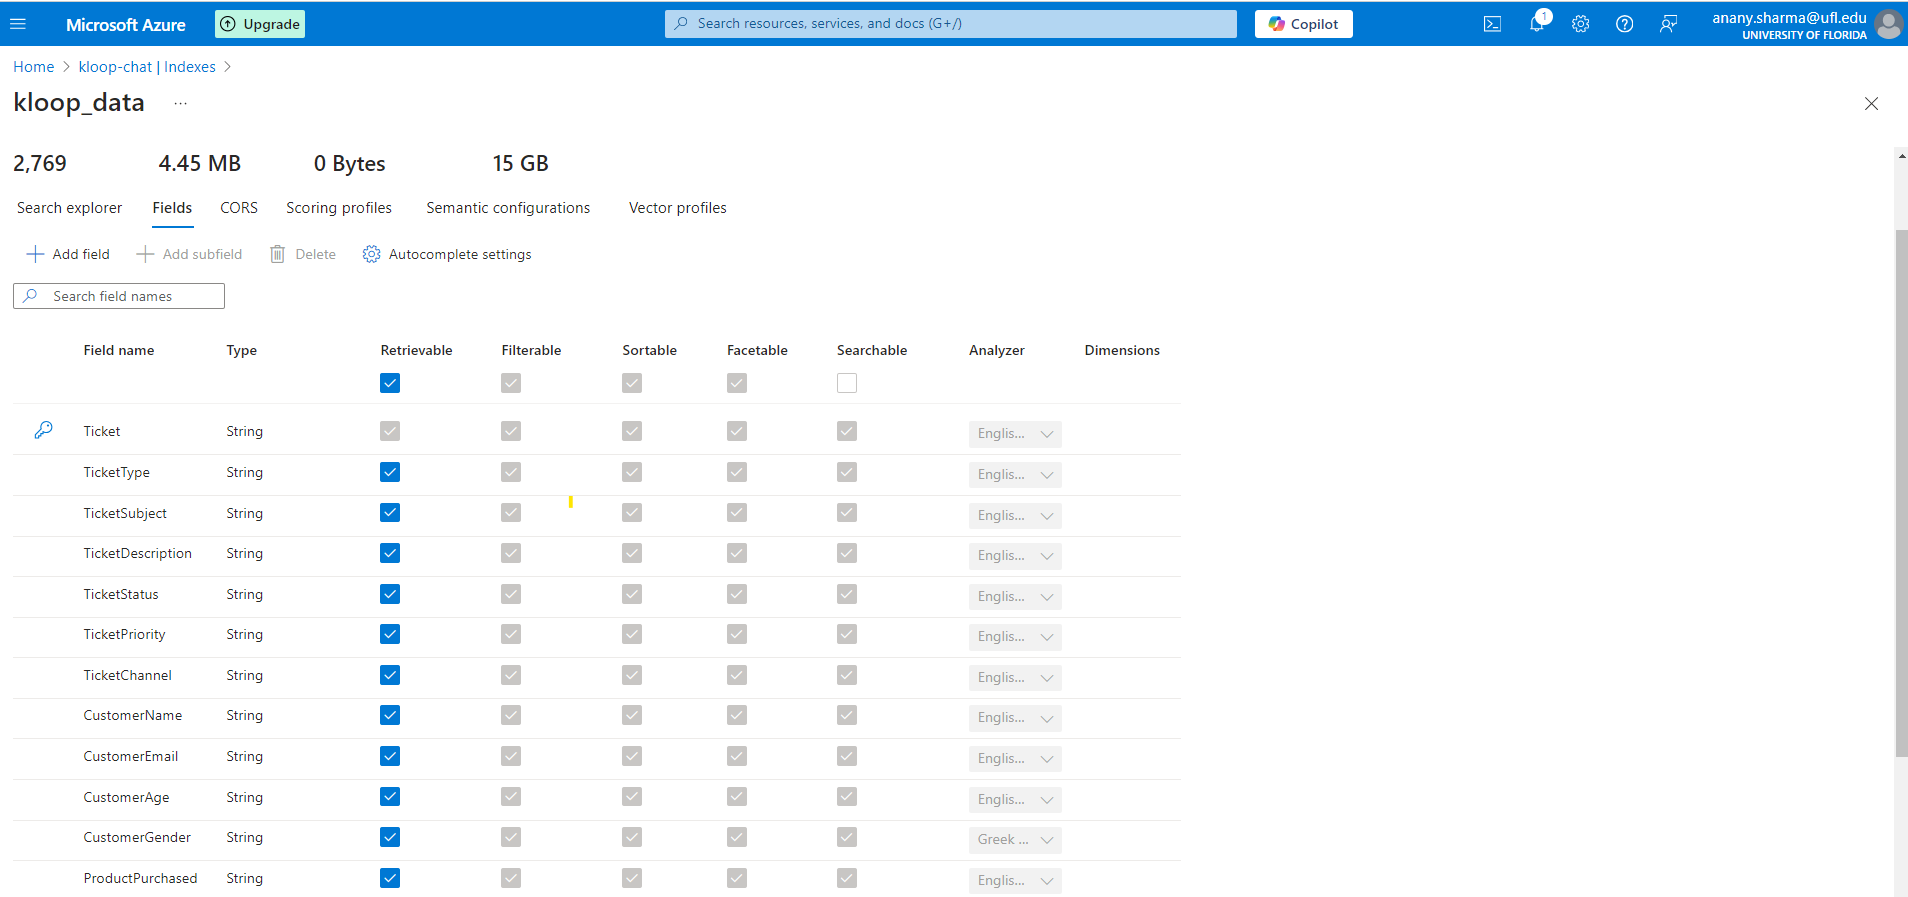

In [12]:
from IPython.display import Image
Image('kloop_data_desc.png', width=600)

In [13]:
#Preparing data to append such that each row is 

for _, row in df_cleaned.iterrows():
    data.append({
        '@search.action': 'upload',
        "Ticket" : str(row['Ticket ID']),
        "TicketType" : str(row['Ticket Type']),
        "CustomerName" : str(row['Customer Name']),
        "CustomerEmail" : str(row['Customer Email']),
        "CustomerAge" : str(row['Customer Age']),
        "CustomerGender" : str(row['Customer Gender']),
        "ProductPurchased" : str(row['Product Purchased']),
        "DateOfPurchase" : pd.to_datetime(row['Date of Purchase'], errors='coerce').isoformat() + 'Z',
        "TicketSubject" : str(row['Ticket Subject']),
        "TicketDescription" : str(row['Ticket Description']),
        "TicketStatus" : str(row['Ticket Status']),
        "Resolution" : str(row['Resolution']),
        "TicketPriority" : str(row['Ticket Priority']),
        "TicketChannel" : str(row['Ticket Channel']),
        "FirstResponseTime" :  pd.to_datetime(row['First Response Time'], errors='coerce').isoformat() + 'Z' if pd.notnull(row['First Response Time']) else None,
        "TimetoResolution" : pd.to_datetime(row['Time to Resolution'], errors='coerce').isoformat() + 'Z' if pd.notnull(row['Time to Resolution']) else None,
        "CustomerSatisfactionRating" : float(row['Customer Satisfaction Rating'])})

In [14]:
result = searchclient.upload_documents(data)
print(result)

[<azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b9526bdf0>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b9526bf10>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d78070>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d780d0>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d78130>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d78190>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d781f0>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d78250>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d782b0>, <azure.search.documents._generated.models._models_py3.IndexingResult object at 0x152b94d78310>, <azure.search.documents._generated.mode